In [13]:
# Here I would like to build an unsupervised Machine Learning Model using scikit-learn

# Importing the libraries
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib

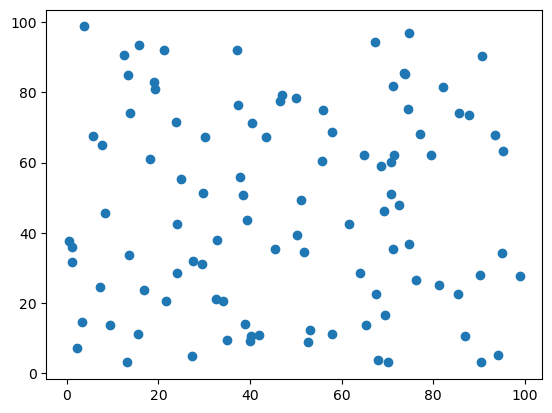

[[0.02727272 0.02761739 0.02796218 ... 0.02199551 0.02172467 0.02145228]
 [0.02759785 0.02794525 0.02829271 ... 0.02260712 0.02233026 0.02205176]
 [0.02792163 0.02827175 0.02862187 ... 0.02322718 0.02294427 0.02265964]
 ...
 [0.04701999 0.04785931 0.0487037  ... 0.19019021 0.18966466 0.18910131]
 [0.04616297 0.04699329 0.04782881 ... 0.18805084 0.18754023 0.18699223]
 [0.04531161 0.04613278 0.04695925 ... 0.18588801 0.18539219 0.1848594 ]]


/tmp/ipykernel_115054/1379171146.py:51: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x,y])


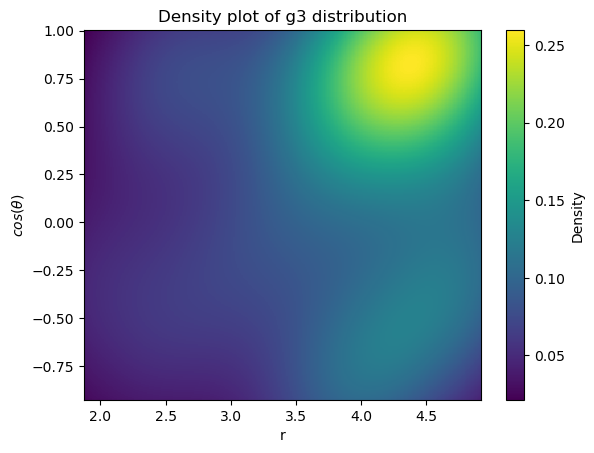

In [14]:
#To quantify local structure, we used the mixed,radial angular,three-particle distribution function, g3(r,θ), which is defined as the probability of finding a particle at a distance r from a reference particle at an angle θ.
# for each point in the coordinates B, we find the nearest neighbor A, and an atom C that is in the cutoff range. 
#We then calculate the angle between the vectors AB and AC. 
#we have the coordinates in the form [[x1,y1,z1] , [x2,y2,z2], ... , [xn,yn,zn]

#lets create random points on 2D plane using numpy and plot them
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import kde

def random_points(n):
    points = []
    for i in range(n):
        x = random.uniform(0, 100)
        y = random.uniform(0, 100)
        points.append([x,y])
    return points

def plot_points(points):
    x = [i[0] for i in points]
    y = [i[1] for i in points]
    plt.scatter(x, y)
    plt.show()

def g3_distribution(com_coordinates,cut_off_radius): 
    r=[]
    cos_theta=[]
    for B in com_coordinates:
        #an array with all coordinates except the current one
        other_coordinates = [i for i in com_coordinates if i != B]
        dist = [np.linalg.norm(np.array(B) - np.array(i)) for i in other_coordinates]
        #find min index
        min_index = dist.index(min(dist))
        A = other_coordinates[min_index]
        
        other_coordinates.remove(A)
        #find the atom C in the cutoff range
        C = [i for i in other_coordinates if np.linalg.norm(np.array(B) - np.array(i)) < cut_off_radius]
        if C:
            #calculate the angle between the vectors AB and AC
            AB = np.array(B) - np.array(A)
            AC = np.array(B) - np.array(C)
            for i in range(len(AC)):
                r.append(np.linalg.norm(AC[i]))
                cos_theta.append(np.dot(AB,AC[i])/(np.linalg.norm(AB)*np.linalg.norm(AC[i])))
    #plot density plot
    x = np.array(r)
    y = np.array(cos_theta)
    nbins=300
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    # Make the plot
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
    print(zi.reshape(xi.shape))
    #adding color bar with min and max written on top and bottom
    plt.colorbar(label='Density')
    plt.title('Density plot of g3 distribution')
    plt.xlabel('r')
    plt.ylabel('$cos(\\theta)$')
    plt.show()


coords=random_points(100)
plot_points(coords)
g3_distribution(coords,5)

In [12]:
#Calculating SSIM using scikit-image
#import scikit-image
import numpy as np
from skimage.metrics import structural_similarity
def SSIM_skimage(dist_1,dist_2):
    return structural_similarity(dist_1,dist_2,data_range=dist_2.max()-dist_2.min(),win_size=7)
#two 2D distributions with values between 0 and 1
dist_1 = np.random.rand(10,10)
dist_2 = np.random.rand(10,10)
SSIM_skimage(dist_1,dist_2)

0.13757215933848374

[[ 1.00000000e+00  9.00236752e-01  8.97719786e-01 ... -1.10842403e-01
  -1.85634143e-01 -1.57524624e-01]
 [ 9.00215691e-01  1.00000000e+00  8.66750267e-01 ... -1.03178722e-01
  -2.14085060e-01 -2.03235506e-01]
 [ 8.98657381e-01  8.67960086e-01  1.00000000e+00 ...  8.60512387e-04
  -1.12024350e-01 -7.53103405e-02]
 ...
 [ 3.29872313e-02  3.93210157e-02  1.32500539e-01 ...  1.00000000e+00
   8.91786169e-01  8.41283167e-01]
 [-3.67569124e-02 -5.71378523e-02  3.57181641e-02 ...  8.91649223e-01
   1.00000000e+00  8.47962462e-01]
 [ 2.86148481e-02 -2.59769973e-03  1.07658393e-01 ...  8.50037824e-01
   8.56241261e-01  1.00000000e+00]]


Text(0, 0.5, 'j')

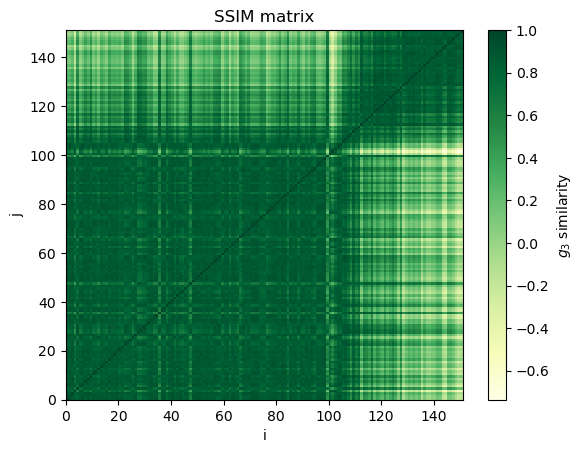

In [60]:
# Load the data from csv file called "g3_dist.csv"
bins_r=401
bins_theta=201
cut_off_r=2
xi, yi = np.mgrid[0:cut_off_r:bins_r*1j, -1:1:bins_theta*1j] # this creates a grid of points
data = pd.read_csv("g3_dist.csv")
data2= pd.read_csv("g3_dist_frac.csv")
#now to merge the two dataframes
data= pd.concat([data, data2],axis=1)

data = data.to_numpy()
#plt.title('Density plot of g3 distribution')
def plot_dist(i):
    zi = np.reshape(data[:,i], xi.shape)
    plt.pcolormesh(xi, yi, zi, shading='auto')
    #plt.colorbar(label='Density')
    #plt.title('Density plot of g3 distribution')
    plt.xlabel('r')
    plt.ylabel('$cos(\\theta)$')
    plt.show()
#Works!

#The SSIM matrix:
SSIM_mat=np.zeros((len(data[0]),len(data[0])))
for i in range(0,len(data[0])):
    zi1 = np.reshape(data[0:,i], xi.shape)
    for j in range(0,len(data[0])):
        zi2 = np.reshape(data[0:,j], xi.shape)
        SSIM_mat[i,j]= (SSIM_skimage(zi1,zi2)-0.8)*5

print(SSIM_mat)

#I want to rotate the y axis so it plots like a matrix
plt.figure()


plt.pcolormesh(SSIM_mat, shading="flat",cmap='YlGn')
plt.colorbar(label='$g_3$ similarity')
plt.title('SSIM matrix')
#now to change the y scale to go from 0 to 100
plt.xlabel('i')
plt.ylabel('j')

[[-9.51401997e+00  3.49051404e+00]
 [-9.27918625e+00  2.89990616e+00]
 [-4.57008839e+00  1.56441689e+00]
 [-1.45417337e+01  4.36895180e+00]
 [ 2.59366727e+00  7.22765923e-01]
 [-1.29212198e+01  4.35439014e+00]
 [-8.53009701e+00  2.71132779e+00]
 [-6.36401892e-01  1.24268985e+00]
 [-5.94514894e+00  1.80900466e+00]
 [ 1.63546181e+00  6.14440262e-01]
 [-1.07376175e+01  3.41458607e+00]
 [-6.74633169e+00  3.47580338e+00]
 [-1.35533495e+01  4.06594181e+00]
 [-3.54165149e+00  2.24160790e+00]
 [-5.14985800e+00  1.24439454e+00]
 [-1.15178432e+01  3.76288295e+00]
 [-7.08988751e-04  8.66652489e-01]
 [-6.12142801e+00  2.63304520e+00]
 [-4.21435928e+00  1.62767208e+00]
 [-6.52402878e+00  1.97727001e+00]
 [-3.03608871e+00  1.05044937e+00]
 [-9.83157158e+00  2.66560006e+00]
 [ 2.64818382e+00  3.37913424e-01]
 [ 1.43768501e+00  4.96162415e-01]
 [-1.91126430e+00  1.29501307e+00]
 [-1.35139799e+01  4.16224432e+00]
 [-4.31079817e+00  2.49602175e+00]
 [ 4.21806574e+00  1.41003042e-01]
 [ 3.85605311e+00  2

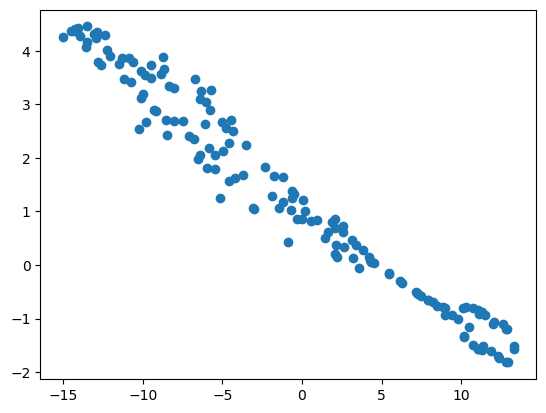

In [51]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming you have a similarity matrix stored in variable 'similarity_matrix'

# Convert similarity matrix to distance matrix
distance_matrix = 1 - SSIM_mat

# Apply PCA to reduce dimensionality
pca = PCA()  # You may need to adjust the number of components
X_pca = pca.fit_transform(distance_matrix)

# Apply t-SNE to reduce dimensionality further
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_pca) 
print(X_embedded)
# Plot the 2D points
plt.figure()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])


N x N similarity matrix for all distributions

In [63]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# def cluster_distributions(SSIM_mat,eps,min_samples):
#     # Convert similarity matrix to distance matrix
#     distance_matrix = 1 - SSIM_mat

#     # Instantiate DBSCAN
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)

#     # Fit the model to the distance matrix
#     dbscan.fit(distance_matrix)

#     # Accessing the cluster labels
#     labels = dbscan.labels_
#     print(labels)
#     # Visualize the clusters
#     plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis')
#     plt.colorbar()
#     plt.show()

# # Generate a random similarity matrix (replace this with your actual similarity matrix)
# cluster_distributions(SSIM_mat,0.085,2)

# Convert similarity matrix to distance matrix
distance_matrix = 1 - SSIM_mat

# Instantiate DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)

# Fit the model to the distance matrix
dbscan.fit(distance_matrix)

# Accessing the cluster labels
labels = dbscan.labels_
print(labels)
# Visualize the clusters

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  2  0 -1  0  0  0  0  0  0  2  0  1  0  2  2  2  2  1  2  2  2
  2  2  2  2  2  2  2  2  3  2  2  2  2  2  2  3  2  3  3  4  4  2  2  3
  5  2  2  4  3  5  3]
